# Projet Science des données: Prédiction de sinistres automobiles

Ce notebook implémente les étapes d'un projet de classification supervisée selon les consignes de `projet_2023.pdf`:
- Importation des données
- Exploration et examen des données
- Préparation et prétraitement
- Analyse des corrélations
- Séparation jeux d'apprentissage et test
- Entraînement de modèles (régression logistique)
- Évaluation et validation croisée
- Comparaison de plusieurs classifieurs
- Sauvegarde du meilleur modèle

## 1. Importation des données

In [16]:
import pandas as pd

df = pd.read_csv('data/car_insurance.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


## 2. Exploration et examen des données

(10000, 18)
id                       int64
age                      int64
gender                   int64
driving_experience      object
education               object
income                  object
credit_score           float64
vehicle_ownership      float64
vehicle_year            object
married                float64
children               float64
postal_code              int64
annual_mileage         float64
vehicle_type            object
speeding_violations      int64
duis                     int64
past_accidents           int64
outcome                float64
dtype: object
id                       0
age                      0
gender                   0
driving_experience       0
education                0
income                   0
credit_score           982
vehicle_ownership        0
vehicle_year             0
married                  0
children                 0
postal_code              0
annual_mileage         957
vehicle_type             0
speeding_violations      0
duis       

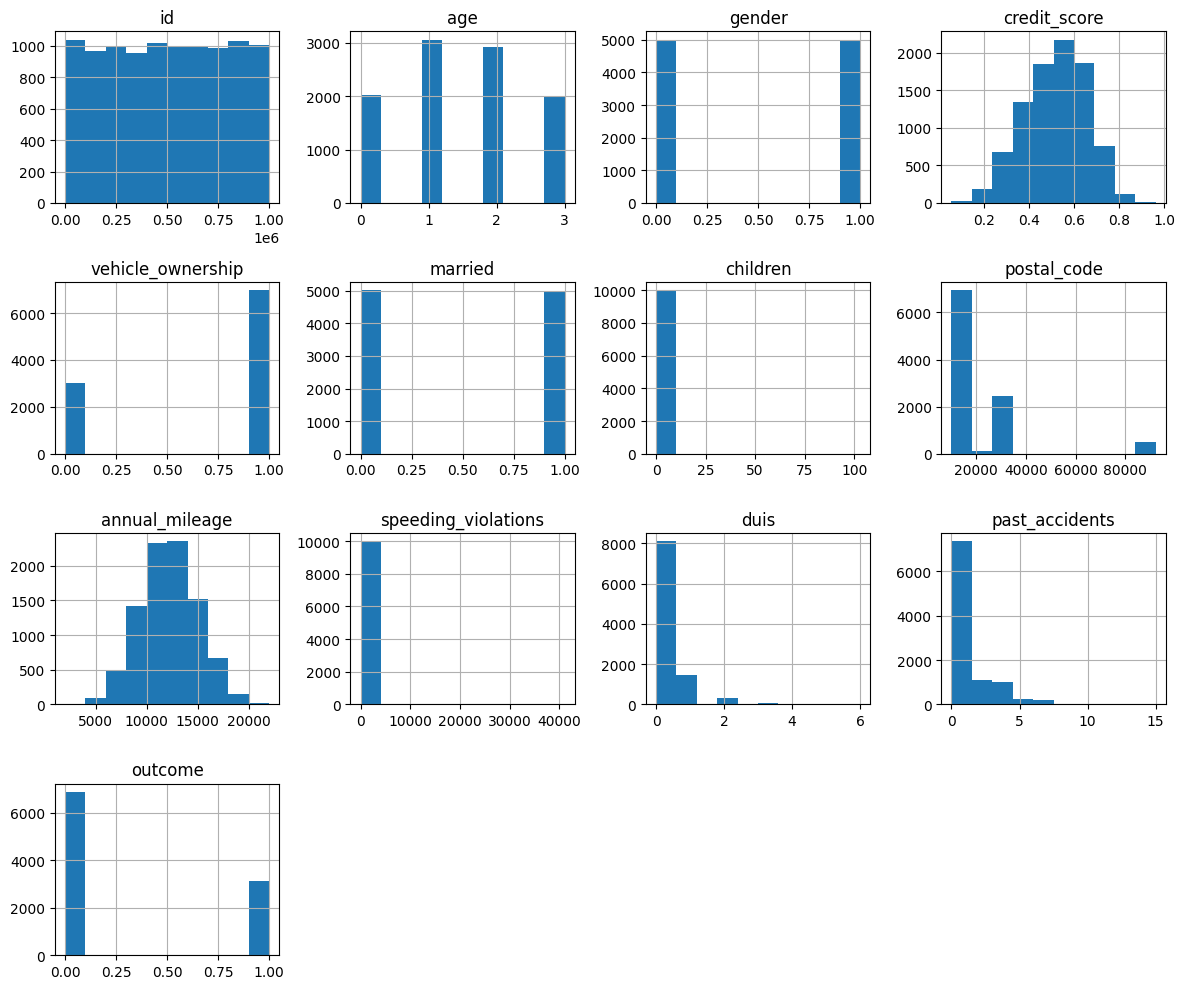

In [17]:
import matplotlib.pyplot as plt

print(df.shape)
print(df.dtypes)
print(df.isna().sum())
df.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()


## 3. Préparation des données

In [22]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

def preprocess_data(df: pd.DataFrame) -> (pd.DataFrame, pd.Series):

    df_clean = df.copy()
    # Suppression des colonnes non utiles ou avec trop de NA
    # df_clean.drop(columns=[...], inplace=True)
    
    # Remplacement des NA numériques par la médiane
    numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())

    # Encodage des catégorielles
    cat_cols = df_clean.select_dtypes(include=['object']).columns
    le = LabelEncoder()
    for col in cat_cols:
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    
    # Extraction X et y
    X = df_clean.drop(columns=['id', 'outcome'])
    y = df_clean['outcome']
    
    # Normalisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = np.nan_to_num(X_scaled, nan=0.0, posinf=0.0, neginf=0.0)
    
    return pd.DataFrame(X_scaled, columns=X.columns), y

# Prétraitement
X, y = preprocess_data(df)

## 4. Analyse des corrélations

Corrélation avec la variable cible :
 outcome                1.000000
vehicle_year           0.294178
annual_mileage         0.178041
gender                 0.107208
postal_code            0.095889
vehicle_type           0.005620
speeding_violations   -0.003746
income                -0.047560
children              -0.058122
education             -0.092643
duis                  -0.189352
married               -0.261807
credit_score          -0.308998
past_accidents        -0.311495
vehicle_ownership     -0.378921
age                   -0.448463
driving_experience    -0.497431
Name: outcome, dtype: float64


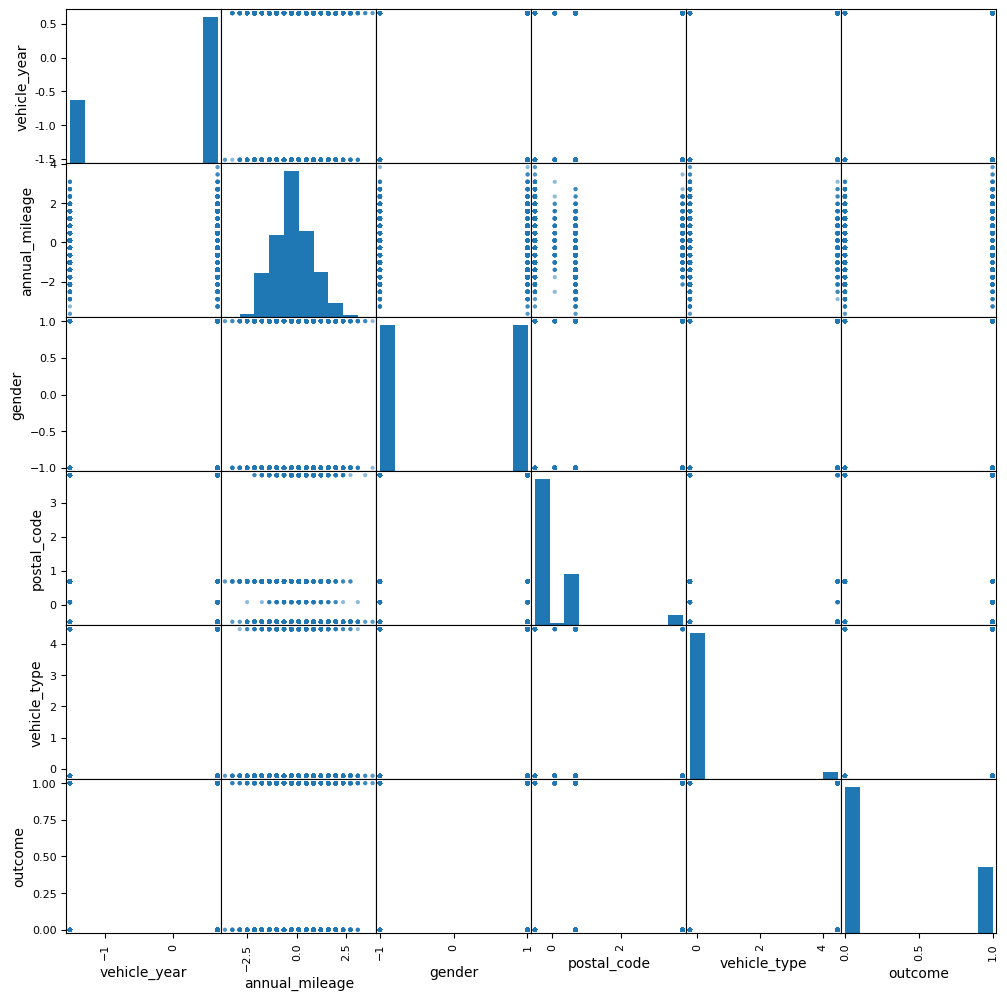

In [5]:
def analyze_correlations(X: pd.DataFrame, y: pd.Series) -> None:
    """Calcule et affiche la corrélation avec la cible et entre variables."""
    df_corr = X.copy()
    df_corr['outcome'] = y
    corr_with_target = df_corr.corr()['outcome'].sort_values(ascending=False)
    print("Corrélation avec la variable cible :\n", corr_with_target)
    # Afficher scatter matrix pour les 5 variables les plus corrélées
    top_vars = corr_with_target.index[1:6].tolist()
    pd.plotting.scatter_matrix(df_corr[top_vars + ['outcome']], figsize=(12, 12))
    plt.show()

# Analyse des corrélations
analyze_correlations(X, y)

## 5. Séparation des jeux d'apprentissage et de test

In [6]:
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.3, random_state=42):
    """Sépare les données en ensembles d'entraînement et de test."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

X_train, X_test, y_train, y_test = split_data(X, y)
print(f"Taille training: {X_train.shape}, test: {X_test.shape}")

Taille training: (7000, 16), test: (3000, 16)


## 6. Entraînement et évaluation d'un modèle de régression logistique

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def train_logistic_regression(X_train, y_train):
    """Entraîne un modèle de régression logistique."""
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """Évalue un modèle et affiche les métriques classiques."""
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

# Entraînement et évaluation
model_lr = train_logistic_regression(X_train, y_train)
evaluate_model(model_lr, X_test, y_test)

Accuracy: 0.8403333333333334
Confusion Matrix:
 [[1848  215]
 [ 264  673]]
Precision: 0.7578828828828829
Recall: 0.7182497331910352
F1 Score: 0.7375342465753425


/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = 

## 7. Validation croisée

In [8]:
from sklearn.model_selection import cross_val_score, KFold

def cross_validate_model(model, X, y, cv=5):
    """Réalise une validation croisée et affiche les scores."""
    scores = cross_val_score(model, X, y, cv=cv)
    print(f"Scores CV ({cv} folds):", scores)
    print("Moyenne:", scores.mean())

# Validation croisée
cross_validate_model(LogisticRegression(max_iter=1000), X, y)

Scores CV (5 folds): [0.842  0.847  0.835  0.8495 0.841 ]
Moyenne: 0.8429


/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = 

## 8. Comparaison de plusieurs classifieurs

In [12]:
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier

def compare_classifiers(X, y, cv=5):
    """Compare Régression Logistique, Perceptron et KNN via validation croisée."""
    classifiers = {
        'LogisticRegression': LogisticRegression(max_iter=1000),
        'Perceptron': Perceptron(),
        'KNeighbors': KNeighborsClassifier()
    }
    for name, clf in classifiers.items():
        scores = cross_val_score(clf, X, y, cv=cv)
        print(f" {name} CV mean: {scores.mean():.4f}")

# Comparaison
compare_classifiers(X, y)

/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/matys/Desktop/Formation/IMT_Nord_Europe/CI 1/S2/DataScience/ProjetDataScience/.venv/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = 

 LogisticRegression CV mean: 0.8429
 Perceptron CV mean: 0.7575
 KNeighbors CV mean: 0.8127


## 9. Sauvegarde du meilleur modèle

In [21]:
import pickle

def save_model(model, filename: str):
    """Sauvegarde un modèle entraîné au format Pickle."""
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

# Exemple de sauvegarde
save_model(model_lr, 'best_model.pkl')
print("Modèle sauvegardé sous 'best_model.pkl'")

Modèle sauvegardé sous 'best_model.pkl'
